In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from scipy import stats
from bs4 import BeautifulSoup
import urllib
import sys
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.patches as patches
import requests 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

sns.set_palette("Blues_d")


In [3]:
df = pd.read_excel('Census_2/2_Clean_Data/Crime_Census_Merged_Imputed_No_Dummies.xlsx')

In [4]:
df.msa_id[df.msa_id== 31080] = 31100 
df['All families - Percent below poverty level; Families'][df['All families - Percent below poverty level; Families']< 0] = 0 
df['Employed; EDUCATIONAL ATTAINMENT - Population 25 to 64 years'][df['Employed; EDUCATIONAL ATTAINMENT - Population 25 to 64 years']< 0] = 0 
df['Total; Median earnings (dollars)'][df['Total; Median earnings (dollars)']< 0] = 0 


The following table shows us some of the main variables that we will be using for for our exploratory data analysis. We have annual observations of US Metropolitan State Areas for the period 2006-2016 with their respective IDs and with demographic variables such as total population, median income, poverty and education levels, among others. 

In [5]:
df_small = df[df['msa_id'].isin(df.loc[df['tot_pop'] > 3000000, 'msa_id'])]
df_small[['tot_pop', 'msa_name', 'msa_id', 'year']].head()


,tot_pop,msa_name,msa_id,year
168,5790619.0,"Atlanta-Sandy Springs-Roswell, GA",12060.0,2016.0
169,5704839.0,"Atlanta-Sandy Springs-Roswell, GA",12060.0,2015.0
170,5597635.0,"Atlanta-Sandy Springs-Roswell, GA",12060.0,2014.0
171,5511212.0,"Atlanta-Sandy Springs-Roswell, GA",12060.0,2013.0
172,5434540.0,"Atlanta-Sandy Springs-Marietta, GA",12060.0,2012.0


In [6]:
df_small_2016= df_small[df_small['year'] == 2016]

In [7]:
labels = ['Atlanta-Sandy Springs-Marietta', 'Boston-Cambridge-Newton', 'Chicago-Naperville-Elgin', 'Dallas-Fort Worth-Arlington', 'Detroit-Warren-Livonia','Houston-Sugar Land-Baytown','Los Angeles-Long Beach-Anaheim','Miami-Fort Lauderdale-Miami Beach','Minneapolis-St. Paul-Bloomington','New York-Newark-Jersey City','Philadelphia-Camden-Wilmington','Phoenix-Mesa-Scottsdale','Riverside-San Bernardino-Ontario','San Diego-Carlsbad-San Marcos','San Francisco-Oakland-Fremont','Seattle-Tacoma-Bellevue','Tampa-St. Petersburg-Clearwater','Washington-Arlington-Alexandria']
labels_alt = ['Atlanta', 'Boston', 'Chicago', 'Dallas', 'Detroit','Houston','Los Angeles','Miami','Minneapolis','New York','Philadelphia','Phoenix','Riverside','San Diego','San Francisco','Seattle','Tampa','Washington']


In our database we have over 400 MSAs for each available year. For simplicity, we limit our preliminary analysis to the MSAs with the largest populations. Although MSAs are generally composed of 2-3 cities, here we name them after their largest city. 

The 18 MSAs chosen for the analysis and their respective populations in 2016 are shown below. 

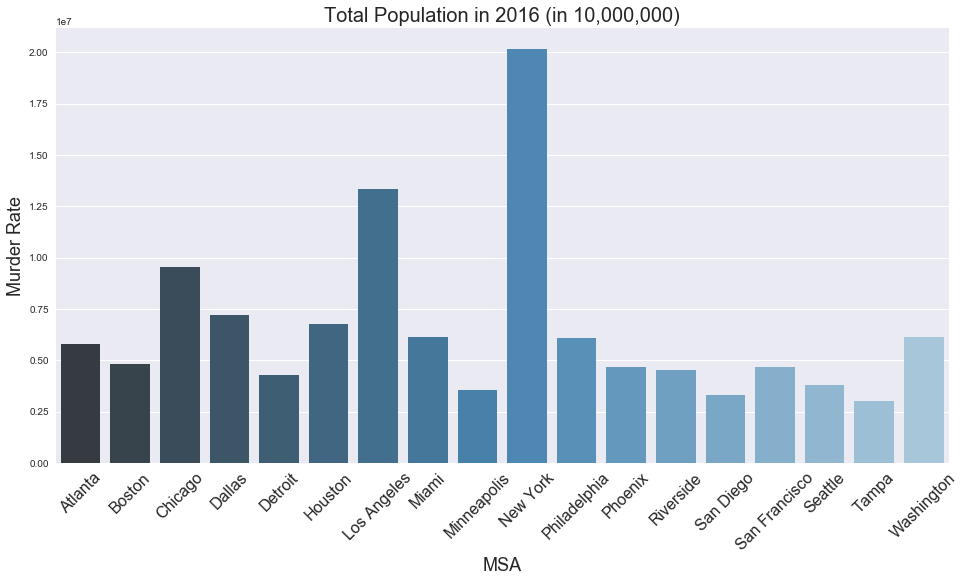

In [9]:

sns.set()

fig, ax = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k', sharey=False);

sns.barplot(x="msa_id", y="tot_pop", data=df_small_2016, palette="Blues_d", ax=ax).set_title("Total Population in 2016 (in 10,000,000)");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=12);

plt.xlabel('MSA', fontsize=18);
plt.ylabel('Murder Rate', fontsize=18);

ax.set_title("Total Population in 2016 (in 10,000,000)", fontsize=20);
ax.set_xticklabels(labels_alt, rotation=45, size=16);


In [11]:
df["violent_crime_rate"] = (df["rep_violent_crime"]/df["tot_pop"])*100000
df["murder_rate"] = (df["rep_murder"]/df["tot_pop"])*100000
df["rape_rate"] = (df["rep_rape"]/df["tot_pop"])*100000
df["robbery_rate"] = (df["rep_robbery"]/df["tot_pop"])*100000
df["agg_assault_rate"] = (df["rep_agg_assault"]/df["tot_pop"])*100000

df_small["violent_crime_rate"] = (df_small["rep_violent_crime"]/df_small["tot_pop"])*100000
df_small["murder_rate"] = (df_small["rep_murder"]/df_small["tot_pop"])*100000
df_small["rape_rate"] = (df_small["rep_rape"]/df_small["tot_pop"])*100000
df_small["robbery_rate"] = (df_small["rep_robbery"]/df_small["tot_pop"])*100000
df_small["agg_assault_rate"] = (df_small["rep_agg_assault"]/df_small["tot_pop"])*100000

df_small_2016["violent_crime_rate"] = (df_small_2016["rep_violent_crime"]/df_small_2016["tot_pop"])*100000
df_small_2016["murder_rate"] = (df_small_2016["rep_murder"]/df_small_2016["tot_pop"])*100000
df_small_2016["rape_rate"] = (df_small_2016["rep_rape"]/df_small_2016["tot_pop"])*100000
df_small_2016["robbery_rate"] = (df_small_2016["rep_robbery"]/df_small_2016["tot_pop"])*100000
df_small_2016["agg_assault_rate"] = (df_small_2016["rep_agg_assault"]/df_small_2016["tot_pop"])*100000


In [12]:
df['high_murder'] = np.where(df['murder_rate']>=4, 1, 0)
df_small['high_murder'] = np.where(df_small['murder_rate']>=4, 1, 0)
df_small_2016['high_murder'] = np.where(df_small_2016['murder_rate']>=4, 1, 0)


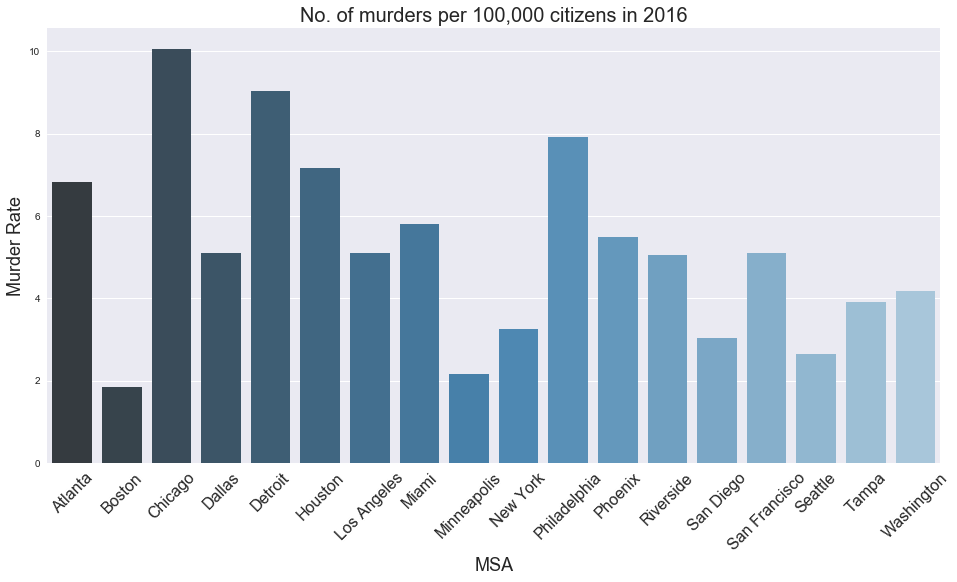

In [13]:
fig, ax = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k');

sns.barplot(x="msa_id", y="murder_rate", data=df_small_2016, palette="Blues_d", ax=ax).set_title("No. of Murders (per 100,000 citizens) in 2016");

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=12);
plt.xlabel('MSA', fontsize=18);
plt.ylabel('Murder Rate', fontsize=18);

ax.set_title("No. of murders per 100,000 citizens in 2016", fontsize=20);

ax.set_xticklabels(labels_alt, rotation=45, size=16);


Because the purpose of our analysis is to build a model to predict murder in the next few years, below we show the average number of reported murders per 100,000 inhabitants for the chosen MSAs across 2006-2016. From the graph below we can see that the MSAs with the highest murder rates (among the MSAs chosen) are those corresponding to Detroit-Warren-Livonia and New York-Newark-Jersey City. 

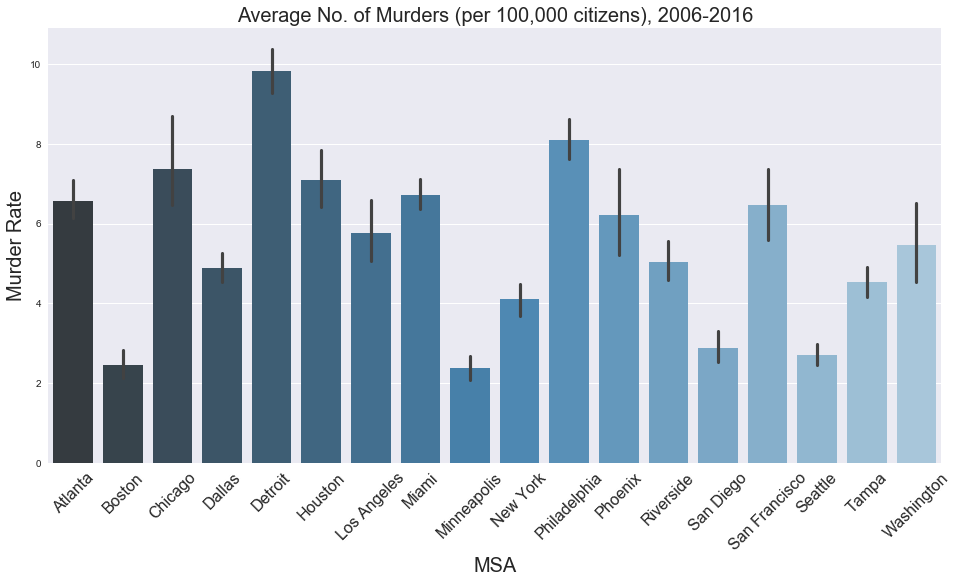

In [14]:
fig, ax = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k');

sns.barplot(x="msa_id", y="murder_rate", data=df_small, palette="Blues_d", ax=ax).set_title("Average No. of Murders (per 100,000 citizens), 2006-2016");

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=12);

plt.xlabel('MSA', size=20);
plt.ylabel('Murder Rate', size=20);

ax.set_title("Average No. of Murders (per 100,000 citizens), 2006-2016", fontsize=20);

ax.set_xticklabels(labels_alt, rotation=45, size=16);


In [17]:
df_red = df_small[['violent_crime_rate','murder_rate','rape_rate','robbery_rate','agg_assault_rate']]

df_red = df_red.dropna(axis=0, how='any')


We have a rich FBI database that includes data on other type of crimes such as rape, robbery, assault, and violent crime.

When we assess the correlation between these different types of crime we can see that they are highly correlated among themselves. Although we are limiting our analysis to murder cases, the high correlation between these  suggest that there are general patterns that are consistent across different types of crimes, and an increasing trend in the number of reported murders might be indicative of similar trends among other types of crime. 

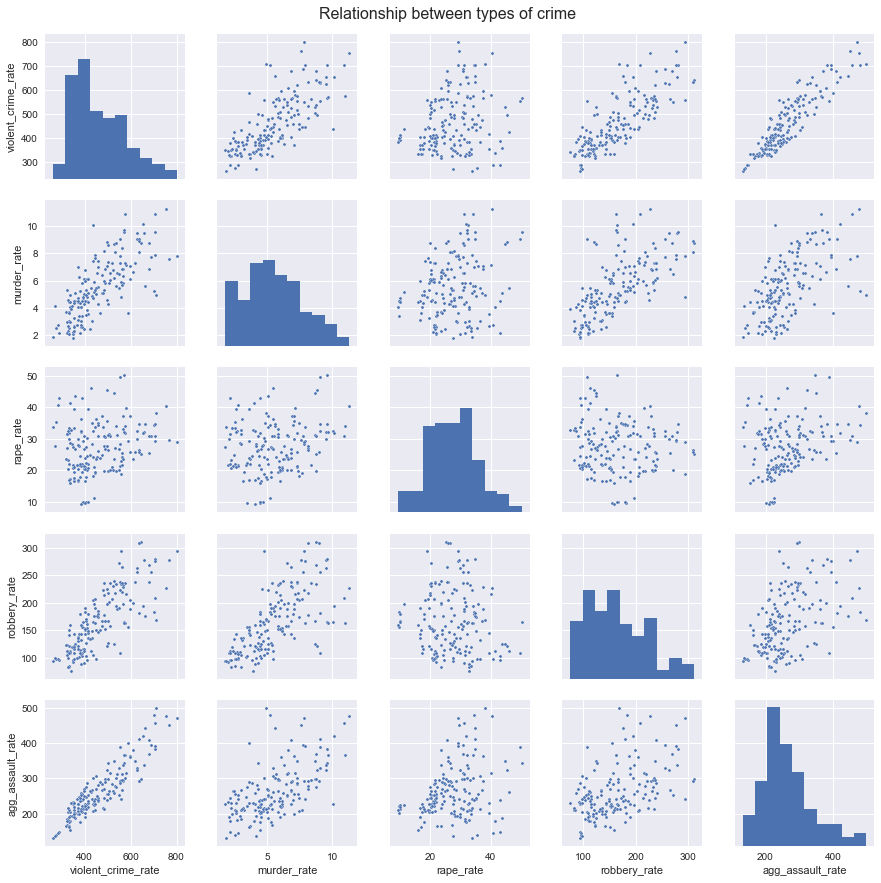

In [20]:
sns.set();
p = sns.pairplot(df_red, plot_kws={"s": 10});
plt.subplots_adjust(top=0.95);
plt.suptitle('Relationship between types of crime', fontsize=16);
#plt.rcParams["axes.labelsize"] = 0.1

In [21]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)

When we assess the number of reported murders per 100,000 inhabitants across these 18 MSAs we identify an upward trend: for the largest MSAs in the US the number of reported murders has been increasing in the last 10 years. 

In [22]:
df_small["msa"] = df_small["msa_id"].map({12060: "Atlanta", 14460: "Boston", 16980: "Chicago", 19100: "Dallas", 19820: "Detroit", 26420: "Houston", 31100: "Los Angeles", 33100: "Miami", 33460: "Minneapolis", 35620: "New York", 37980: "Philadelphia", 38060: "Phoenix", 40140: "Riverside", 41740: "San Diego", 41860: "San Francisco", 42660: "Seattle", 45300: "Tampa", 47900:"Washington"})



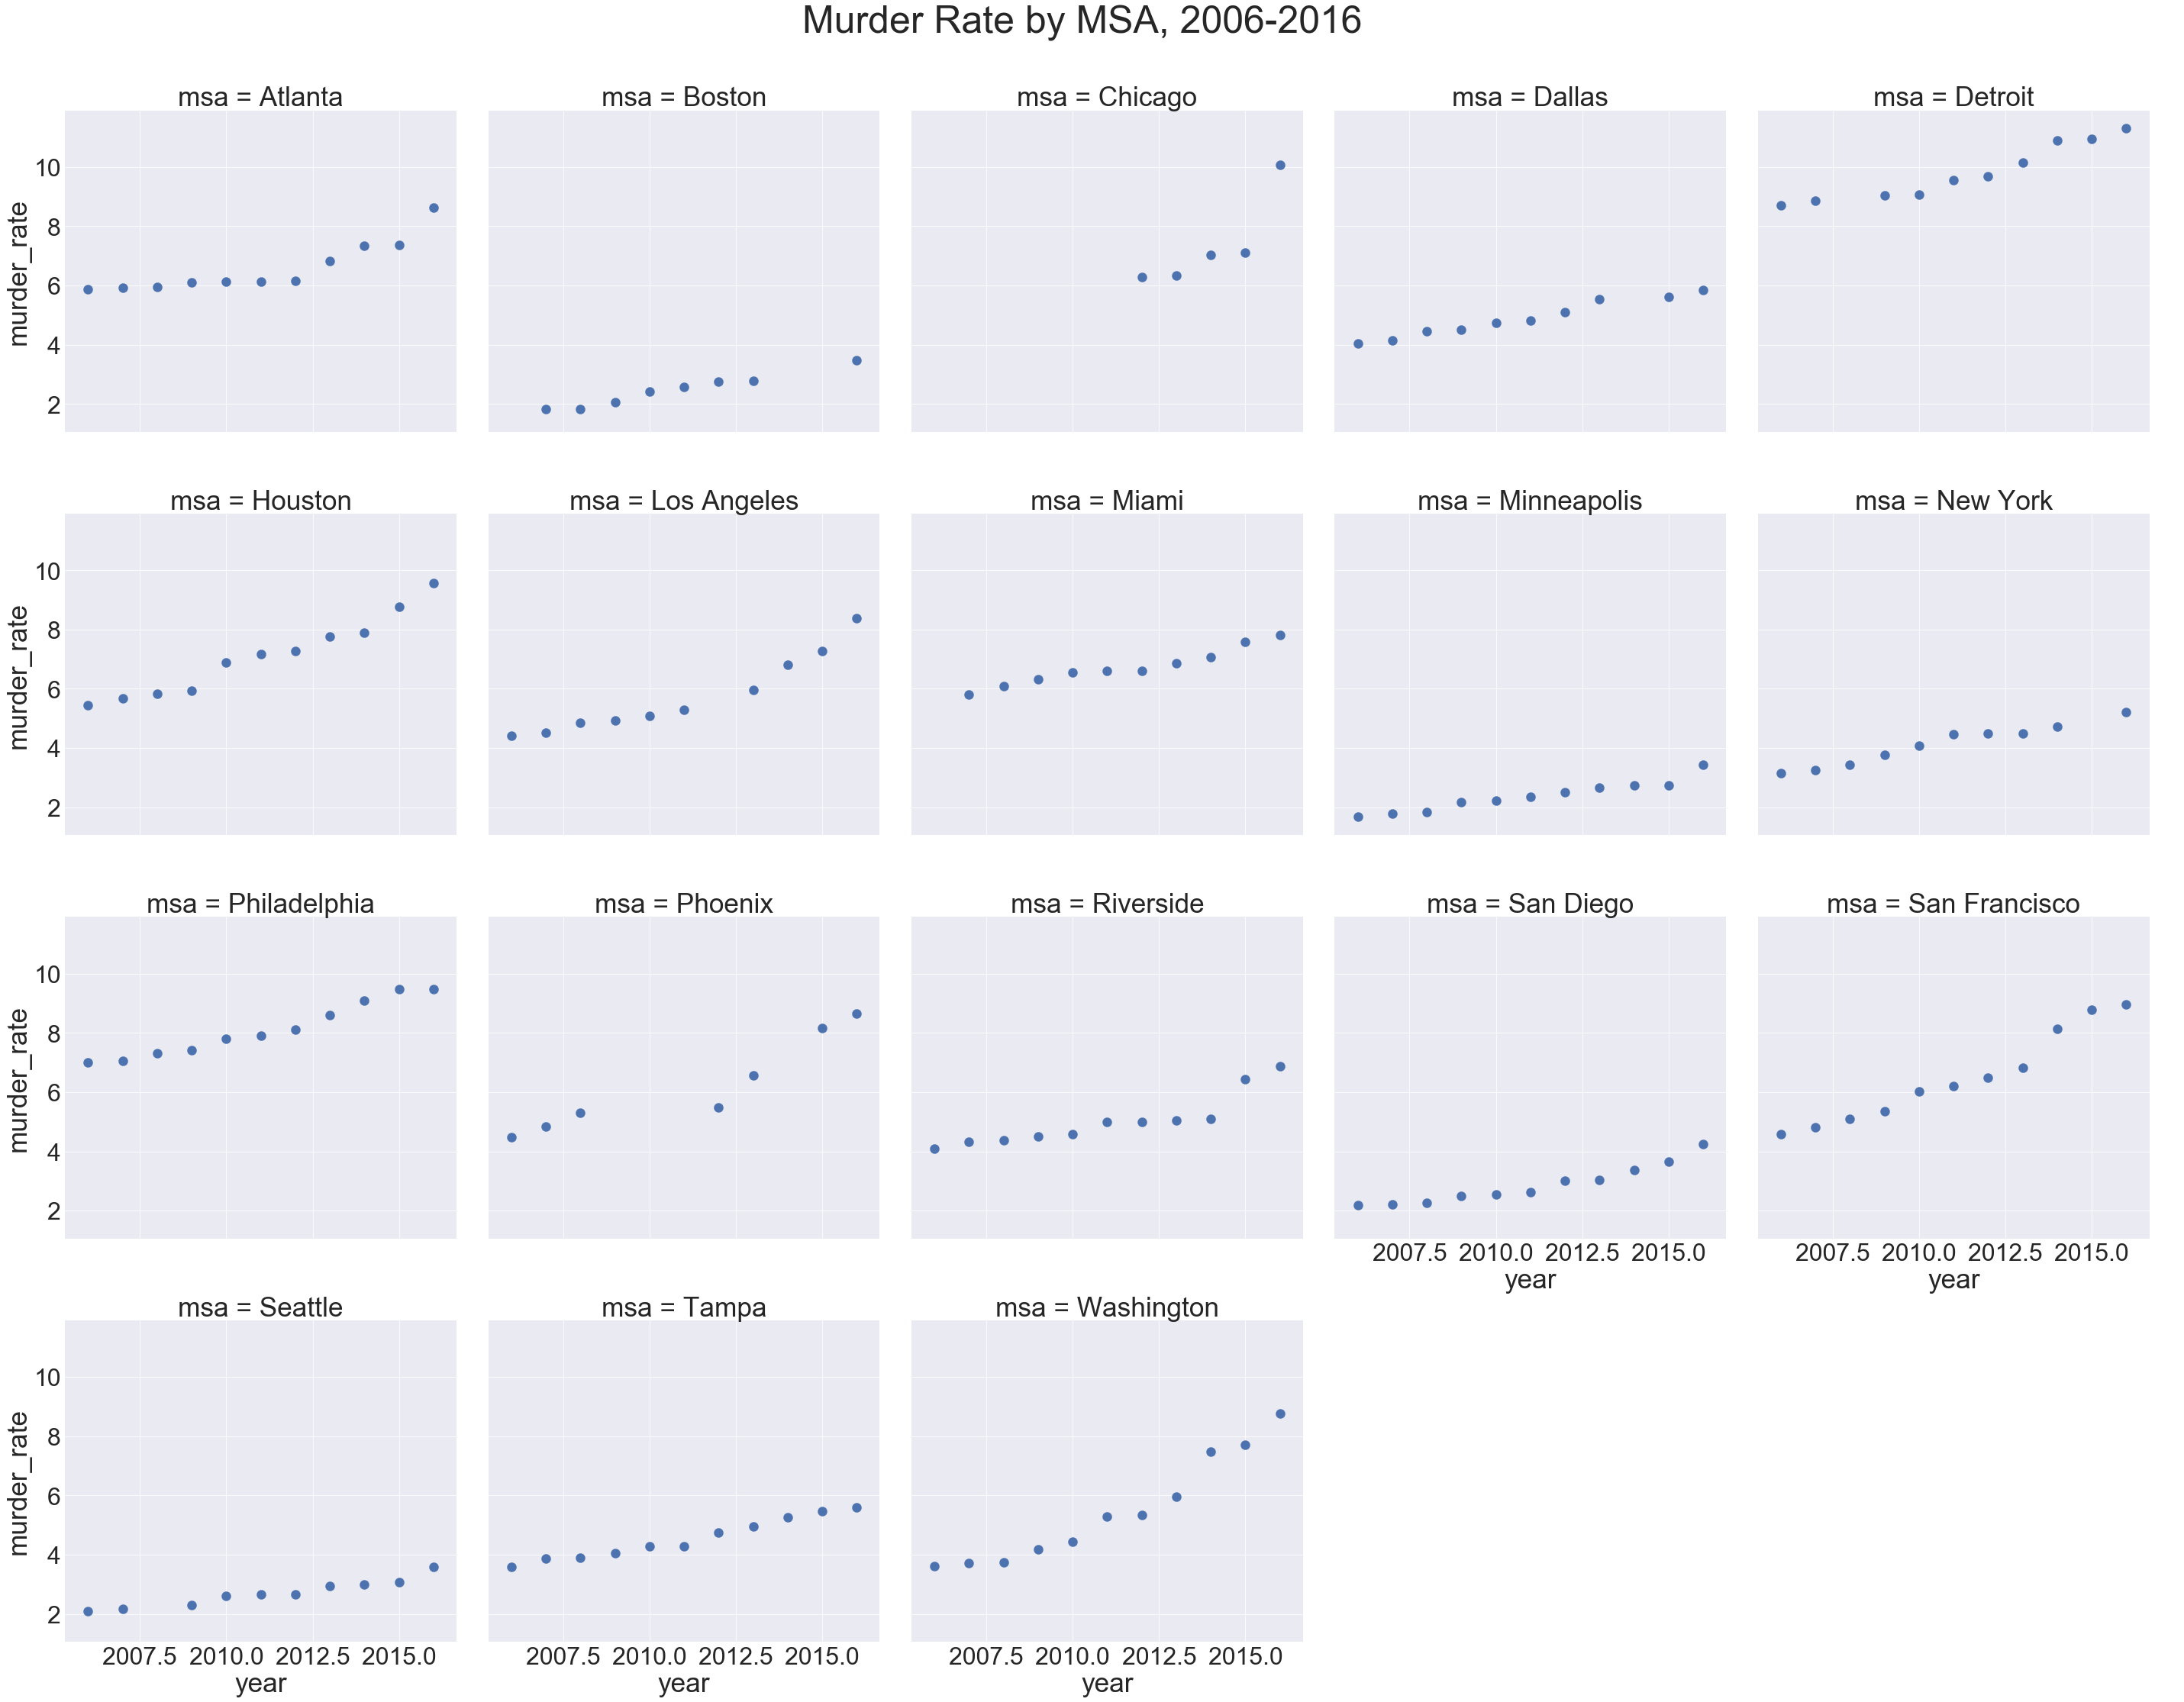

In [23]:
sns.set_context("paper", font_scale=4)                                                  
g = sns.FacetGrid(df_small, col="msa", size=8, col_wrap=5)
g.map(qqplot, "year", "murder_rate", s=150)
g.add_legend();
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Murder Rate by MSA, 2006-2016', fontsize=50)


In [24]:
len(df_small.msa_id.unique())

18

In [25]:
df['per_capita_income']=df['Mean income (dollars); per capita income Total population']
df['poverty_rate']=df['All families - Percent below poverty level; Families']
df['receives_foodstamp']=df['Households receiving food stamps; Households']
df['unemployment_rate']=df['Unemployment rate; Population 20 to 64 years']
df['median_earnings']=df['Total; Median earnings (dollars)']

df_small['per_capita_income']=df_small['Mean income (dollars); per capita income Total population']
df_small['poverty_rate']=df_small['All families - Percent below poverty level; Families']
df_small['receives_foodstamp']=df_small['Households receiving food stamps; Households']
df_small['unemployment_rate']=df_small['Unemployment rate; Population 20 to 64 years']
df_small['median_earnings']=df_small['Total; Median earnings (dollars)']



We assess the correlation between murder rates and some of the demographic variables available in the census data. In general, we observe patterns that are consistent with what one would expect:

1. MSAs with higher poverty rates are associated with higher murder rates.
2. MSAs with higher income per capita or with higher levels of median earnings are associated with higher murder rates. 
3. MSAs with higher unemployment rates are associated with higher murder rates. 

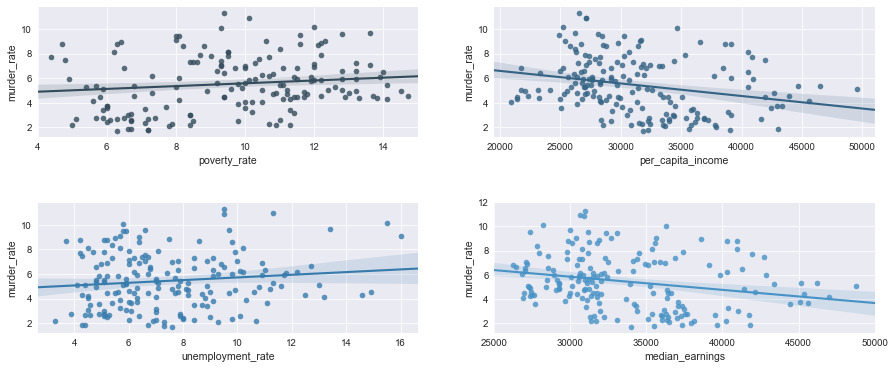

In [122]:
sns.set_palette("Blues_d")


sns.set_context("paper", font_scale=1.2)                                                  

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (15, 6), facecolor = 'w', edgecolor = 'k', sharey = False)

sns.regplot(x="poverty_rate", y="murder_rate", data=df_small, ax=ax1)
sns.regplot(x="per_capita_income", y="murder_rate", data=df_small, ax=ax2)
sns.regplot(x='unemployment_rate', y="murder_rate", data=df_small, ax=ax3)
sns.regplot(x='median_earnings', y="murder_rate", data=df_small, ax=ax4)

ax1.set_xlim([4,15]) 
ax4.set_xlim([25000,50000]) 

fig.subplots_adjust(hspace = 0.5, wspace=.2)



For the following analysis we use all 400+ MSAs in the US and limit our sample to the year 2016. Moreover, we create a variable for "high-murder" areas, where "high-murder" areas are those MSAs where the murder rate exceeds the median murder rate for 2016, which was approximately 4. 

By doing this we observe some interesting differences between high vs. low murder areas. First, we see that poverty rates are on average higher in high-murder areas than in low-murder ones. Second, we find that there's on average higher unemployment rates in high-murder areas. 

Our most interesting finding is related to median earnings. We observe that, on average, median income across these two types of areas is very similar. The main difference is that there's slightly less variation in median income in high-murder areas (median incomes are concentrated closer to their mean). Although this is not part of the scope of our analysis, it'd be interesting to assess variation of median income *within* MSAs, as it might be the case that although median income is the same, there might be large variation (and therefore inequality) within MSAs. 


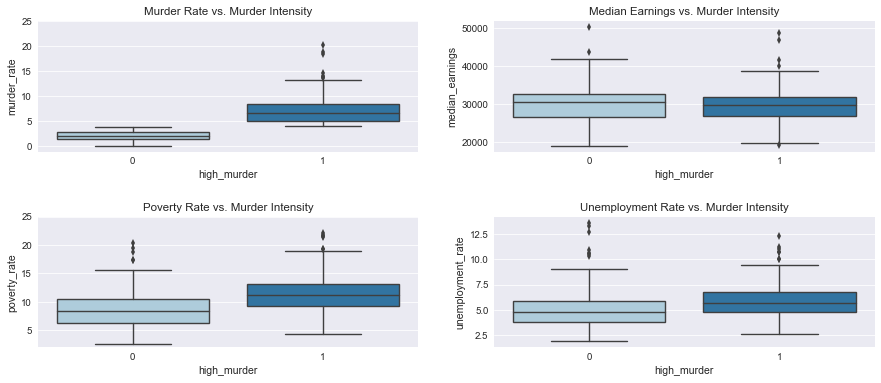

In [118]:
sns.set_palette("Paired")

df_2016= df[df['year'] == 2016]

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (15, 6), facecolor = 'w', edgecolor = 'k', sharey = False)

sns.boxplot(x="high_murder", y="murder_rate", data=df_2016, ax=ax1)
sns.boxplot(x="high_murder", y="median_earnings", data=df_2016, ax=ax2)
sns.boxplot(x="high_murder", y="poverty_rate", data=df_2016, ax=ax3)
sns.boxplot(x="high_murder", y="unemployment_rate", data=df_2016, ax=ax4);

ax1.set_title('Murder Rate vs. Murder Intensity')
ax3.set_title('Poverty Rate vs. Murder Intensity')
ax4.set_title('Unemployment Rate vs. Murder Intensity')
ax2.set_title('Median Earnings vs. Murder Intensity')

ax1.set_ylim([-1,25])
ax3.set_ylim([2,25])

fig.subplots_adjust(hspace = 0.5, wspace=.2)
